# Методы исследования характеристических свойств нейронных сетей с применением теоретико-игрового подхода

- **Теория**: И.В.Томилов ivan-tomilov3@yandex.ru
- **Реализация**: М.А.Зайцева maria@tail-call.ru
- **Поддержка CUDA**: А.Е.Григорьева admin@linkennt.ru
- **Ревизия**: 8

- **Другие ревизии**: [ссылка](https://disk.yandex.ru/d/aZozDpBlzh_z1A)
<!-- please do not append text into this block -->

- [x] Добавить 2x больше эпох на датасетах, где был плохой перфоманс (1, 2, 5, 7, 8)
- [x] Примешивать к целевой переменной на этапе обучения шум с амплитудой ~0,03 дисперсии
- [x] Обучить модели без шума для сравнения
- [ ] Отображать правильную шкалу шума
- [ ] Подмешивать стабильно распределённый шум, варьируя $\alpha$ от 1 до 2

NOTE: levy distribution нам не подходит, у него фиксированная $\alpha = 0.5$


## Setup

In [1]:
from cgtnnlib.constants import LEARNING_RATE, RANDOM_STATE
import cgtnnlib.training as tr
import cgtnnlib.datasets as ds
from cgtnnlib.ExperimentParameters import ExperimentParameters
from cgtnnlib.NoiseGenerator import target_dispersion_scaled_noise, stable_noise, no_noise_generator


iterations = 10
epochs = 10
dataset = ds.datasets[2]
pp = [0.0, 0.5, 0.9]


datasets = [
    ds.datasets['StudentPerformanceFactors'],
    ds.datasets['wine_quality'],
]

ng_makers = [
    lambda dataset: no_noise_generator,
    lambda dataset: target_dispersion_scaled_noise(
        dataset=dataset,
        factor=0.03,
        random_seed=RANDOM_STATE + 1,
    ),
    # lambda dataset: stable_noise(
    #     dataset=dataset,
    #     factor=0.03,
    #     alpha=1,
    #     beta=1,
    # ),
    # lambda dataset: stable_noise(
    #     dataset=dataset,
    #     factor=0.03,
    #     alpha=1.25,
    #     beta=1,
    # ),
    # lambda dataset: stable_noise(
    #     dataset=dataset,
    #     factor=0.03,
    #     alpha=1.5,
    #     beta=1,
    # ),
    # lambda dataset: stable_noise(
    #     dataset=dataset,
    #     factor=0.03,
    #     alpha=1.75,
    #     beta=1,
    # ),
    # lambda dataset: stable_noise(
    #     dataset=dataset,
    #     factor=0.03,
    #     alpha=2.0,
    #     beta=1,
    # ),
]

double_epochs_datasets = [
    ds.datasets[0], # 1
    ds.datasets[1], # 2
    ds.datasets[4], # 5
    ds.datasets[6], # 7
    ds.datasets[7], # 8
]

TORCH_DEVICE is cpu



## Генерация стабильного шума

Используется алгоритм Chambers-Mallows-Stuck (CMS) [1]; в [2] алгоритм дан в прямом виде. Реализация в файле *cgtnnlib/NoiseGenerator.py*.

In [191]:

from cgtnnlib.NoiseGenerator import stable_noise

ng = stable_noise(
    dataset=datasets[0],
    factor=0.03,
    alpha=1,
    beta=0.0
)

print(ng.name)
[ng.next_sample() for _ in range(10)]

Stable3A1B0.0F0.03


[-0.38321799736345374,
 0.0511330462698278,
 0.9768442345137561,
 -0.05562285111784796,
 0.23313989182676834,
 0.5524299343839069,
 0.09726071790864348,
 0.8405802760793538,
 -1.1336032971682826,
 -0.386007229155073]

## Training

- both take ~5m 06s to train 10 iterations
- both on both noises: about ~10m

<hr>

- `ds.datasets['StudentPerformanceFactors']` takes ~2m 30s to train 10 iterations
- `ds.datasets['wine_quality']` takes ~2m 36s to train 10 iterations

### Target noise

In [ ]:
for i, dataset in enumerate(datasets):
    for ng_maker in ng_makers:
        for p in pp:
            noise_generator = ng_maker(dataset)
            for iteration in range(iterations):
                experiment_params = ExperimentParameters(iteration, p=p)

                tr.create_and_train_model(
                    dataset,
                    epochs,
                    learning_rate=LEARNING_RATE,
                    dry_run=False,
                    p=p,
                    iteration=iteration,
                    noise_generator=noise_generator
                )

N=9 #6 gStable6A2.0B1F0.03 p=0.9 E9/10 S434 Loss=nan@AugmentedReLUNetwork
create_and_train_model(): saved model to pth//cgtnn-6Y-AugmentedReLUNetwork-gStable6A2.0B1F0.03-P0.9_N9.pth
Report saved to pth/cgtnn-6Y-AugmentedReLUNetwork-gStable6A2.0B1F0.03-P0.9_N9.json.


### 2x epochs

In [3]:
for i, dataset in enumerate(double_epochs_datasets):
    for p in pp:
        for iteration in range(iterations):
            experiment_params = ExperimentParameters(iteration, p=p)

            tr.create_and_train_model(
                dataset,
                epochs * 2,
                learning_rate=LEARNING_RATE,
                dry_run=False,
                p=p,
                iteration=iteration,
                noise_generator=no_noise_generator
            )

N=9 #8 gNoNoise p=0.9 E19/20 S81 Loss=4.2432@AugmentedReLUNetwork
create_and_train_model(): saved model to pth//cgtnn-8Y-AugmentedReLUNetwork-gNoNoise-P0.9_N9.pth
Report saved to pth/cgtnn-8Y-AugmentedReLUNetwork-gNoNoise-P0.9_N9.json.


## Evaluation

both take 42s

120 take 4m 10.9s

(need evaluation skip check??)

In [ ]:
from cgtnnlib.EvaluationParameters import EvaluationParameters
from cgtnnlib.Report import Report
from cgtnnlib.nn.AugmentedReLUNetwork import AugmentedReLUNetwork
import cgtnnlib.evaluate as ev
import cgtnnlib.datasets as ds
import cgtnnlib.path as ph
from cgtnnlib.ExperimentParameters import ExperimentParameters

## All others

# for i, modelset in enumerate(datasets):
#     for ng_maker in ng_makers:
#         for p in pp:

## 2x epochs
            
for i, dataset in enumerate(double_epochs_datasets):
    for p in pp:
        for iteration in range(iterations):
            
            ## All others

            # noise_generator = ng_maker(modelset)
            
            ## 2x epochs
            
            noise_generator = no_noise_generator

            for iteration in range(iterations):
                experiment_params = ExperimentParameters(iteration, p=p)
                
                eval_params = EvaluationParameters(
                    dataset=dataset,
                    model_path=ph.model_path(
                        dataset_number=dataset.number,
                        model_type=AugmentedReLUNetwork,
                        p=p,
                        iteration=iteration,
                        noise_generator=noise_generator,
                    ),
                    experiment_parameters=experiment_params,
                    report_key=ph.eval_report_key(
                        model_name=AugmentedReLUNetwork.__name__,
                        dataset_number=dataset.number,
                        p=p,
                        iteration=iteration,
                    )
                )
                
                report_name = ph.model_name(
                    dataset_number=dataset.number,
                    model_type=AugmentedReLUNetwork,
                    p=p,
                    iteration=iteration,
                    noise_generator=noise_generator
                )

                report = Report(
                    dir='pth/',
                    filename=report_name + '.json',
                    must_exist=True,
                )
                
                ev.eval_inner(
                    eval_params=eval_params,
                    constructor=AugmentedReLUNetwork,
                    report=report
                )
                
                report.save()

Evaluating model at pth//cgtnn-8Y-AugmentedReLUNetwork-gNoNoise-P0.9_N9.pth...
Report saved to pth/cgtnn-8Y-AugmentedReLUNetwork-gNoNoise-P0.9_N9.json.


## Analysis

         0.25       0.75       mean
0   15.291445  17.160938  16.537011
1   15.325780  17.152957  16.550676
2   15.435536  17.257329  16.595141
3   15.524005  17.239614  16.673583
4   15.441142  17.326709  16.725174
5   15.603337  17.351771  16.866771
6   15.828276  17.756474  17.027679
7   16.060865  17.607718  17.287432
8   16.164557  17.824644  17.490503
9   16.451504  17.950942  17.635470
10  16.762527  18.496246  17.874031
11  16.998802  18.441605  18.104799
12  17.279878  19.020344  18.445516
13  17.707304  19.549057  18.919937
14  18.141398  20.026517  19.540695
15  18.773039  20.276085  19.928098
16  19.026901  20.467012  20.197442
17  19.219180  20.870124  20.501186
18  19.511885  21.292193  21.104711
19  19.711080  21.815368  21.301135
20  20.892270  22.371003  22.228753
21  21.759702  22.775388  22.808801
22  21.722237  23.669284  23.066263
23  22.735703  23.790020  23.949368
24  22.438478  24.700301  24.370407
25  23.831275  26.038329  25.495535
26  24.939415  26.105591  25

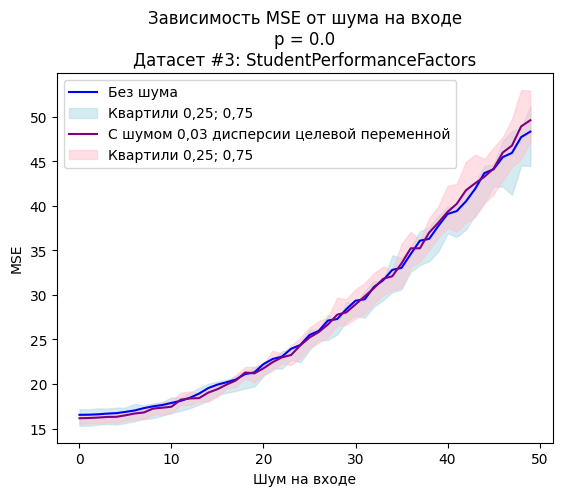

         0.25       0.75       mean
0   17.058297  17.954195  17.997389
1   17.051834  17.987578  18.005648
2   17.095849  18.004382  18.051791
3   17.273563  18.178066  18.196132
4   17.326096  18.104790  18.223167
5   17.374791  18.285011  18.348356
6   17.648692  18.406813  18.508922
7   17.770540  18.951649  18.672835
8   17.832742  19.069180  18.850623
9   18.484638  19.311709  19.302594
10  18.565680  18.961201  19.290079
11  19.101616  19.902329  19.835273
12  18.793574  19.936042  19.849699
13  19.351954  20.839018  20.177058
14  20.175987  20.710776  20.755245
15  20.098016  21.740256  21.166794
16  20.693017  21.791121  21.500819
17  21.102207  22.336267  22.191927
18  21.212377  22.465054  22.253620
19  22.108603  23.512875  22.940814
20  22.312385  23.585788  23.272641
21  23.242090  24.806786  24.037889
22  23.973194  25.063317  24.743099
23  23.673724  25.816811  24.906979
24  25.450507  26.511048  26.015955
25  25.831448  27.117933  26.585048
26  26.152442  28.233149  27

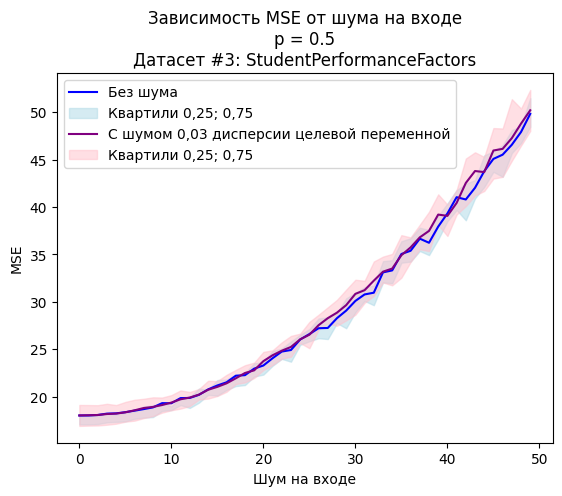

         0.25       0.75       mean
0   17.700145  18.448997  18.316080
1   17.755768  18.490106  18.328244
2   17.720591  18.504062  18.343352
3   17.847672  18.476927  18.412436
4   17.877006  18.674815  18.526331
5   17.821580  18.617532  18.477117
6   17.975447  18.677254  18.650938
7   17.926020  18.793975  18.691649
8   18.459945  18.810290  18.897815
9   18.292559  18.932306  18.810176
10  18.351362  19.213665  19.040380
11  18.750420  19.617247  19.365756
12  18.813096  19.675657  19.460094
13  18.782423  19.901611  19.700833
14  19.544187  19.793639  19.941462
15  19.663770  20.398485  20.268020
16  19.668170  20.257139  20.172828
17  20.214615  20.537009  20.695579
18  20.632920  21.224698  20.953440
19  20.826833  22.113925  21.649239
20  21.197406  22.042734  21.763039
21  20.942674  22.587552  21.723718
22  21.879728  22.856975  22.588553
23  21.969561  23.171882  22.574658
24  22.315275  24.038997  23.260336
25  22.768766  24.182124  23.572500
26  22.828672  24.294666  23

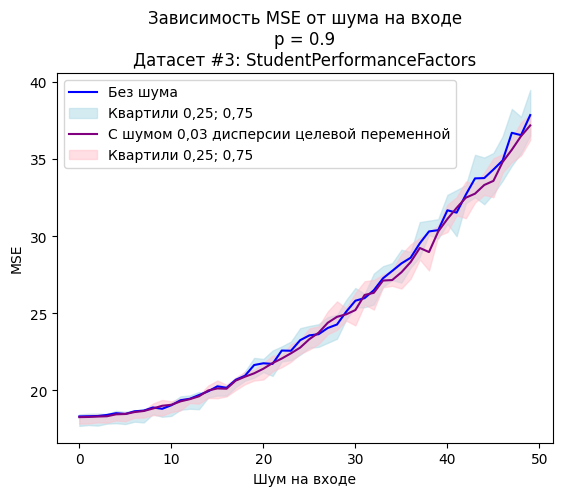

        0.25      0.75      mean
0   0.805174  1.288117  1.135087
1   0.805951  1.291098  1.137354
2   0.809786  1.293516  1.140585
3   0.811778  1.289901  1.143752
4   0.832341  1.293775  1.151302
5   0.826537  1.309905  1.159697
6   0.854393  1.316683  1.173230
7   0.845588  1.306804  1.169057
8   0.871287  1.345111  1.196183
9   0.879136  1.364860  1.204400
10  0.900507  1.367226  1.231136
11  0.919183  1.413914  1.248400
12  0.919878  1.428265  1.266612
13  0.959823  1.445792  1.297443
14  0.978802  1.448847  1.320033
15  1.013718  1.497953  1.350787
16  1.060294  1.524015  1.381639
17  1.084645  1.522814  1.397795
18  1.112649  1.601572  1.431830
19  1.157385  1.628966  1.504953
20  1.199282  1.683163  1.523010
21  1.242463  1.714381  1.556825
22  1.262874  1.720496  1.601870
23  1.334256  1.846074  1.636456
24  1.364127  1.779274  1.681895
25  1.351356  1.895840  1.727537
26  1.457366  1.893257  1.755767
27  1.464613  1.959974  1.823873
28  1.540390  2.035934  1.881533
29  1.6597

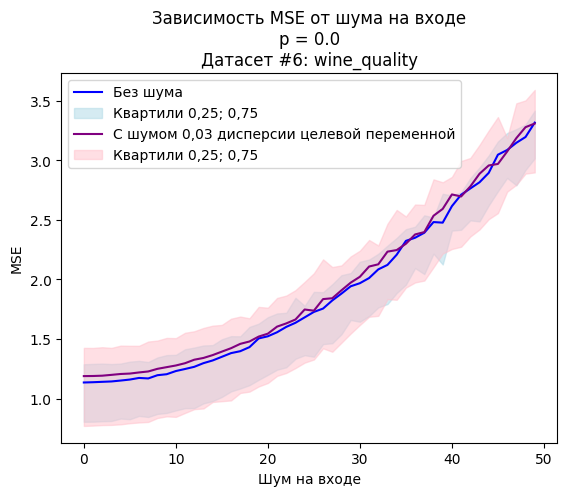

        0.25      0.75      mean
0   0.768181  1.009349  0.935403
1   0.769013  1.009950  0.936266
2   0.776117  1.008913  0.938914
3   0.766645  1.009064  0.939101
4   0.776361  1.025277  0.946560
5   0.781601  1.025003  0.951925
6   0.793321  1.023164  0.957534
7   0.796215  1.038306  0.969393
8   0.796042  1.053112  0.977752
9   0.802841  1.068860  0.991624
10  0.831780  1.061022  0.998775
11  0.840757  1.088670  1.011312
12  0.839581  1.090441  1.015254
13  0.878913  1.110198  1.039216
14  0.891563  1.130293  1.054005
15  0.897402  1.145448  1.070222
16  0.935487  1.172064  1.099250
17  0.942052  1.140213  1.105484
18  0.978198  1.181035  1.131368
19  0.979563  1.212908  1.143598
20  1.010148  1.211341  1.178235
21  1.044491  1.266441  1.212007
22  1.046778  1.289728  1.227812
23  1.085424  1.297671  1.263570
24  1.145573  1.326456  1.304466
25  1.147683  1.347066  1.312134
26  1.192575  1.348556  1.324532
27  1.227020  1.428598  1.384820
28  1.294540  1.380275  1.415104
29  1.2675

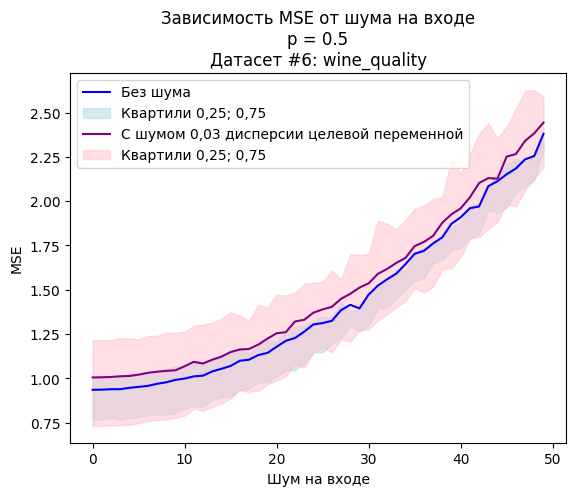

        0.25      0.75      mean
0   0.761602  1.122878  0.953495
1   0.763473  1.123726  0.954394
2   0.763271  1.121834  0.954890
3   0.762576  1.127764  0.955498
4   0.766839  1.122708  0.956454
5   0.768209  1.135762  0.959345
6   0.768911  1.133777  0.961954
7   0.776489  1.146044  0.968884
8   0.778891  1.141939  0.973667
9   0.794823  1.155997  0.977949
10  0.797373  1.158543  0.986363
11  0.794399  1.147008  0.987892
12  0.810535  1.178108  1.001395
13  0.815083  1.166549  1.001809
14  0.822018  1.213221  1.019258
15  0.832046  1.176582  1.023062
16  0.846216  1.230006  1.038430
17  0.855216  1.209790  1.041891
18  0.874159  1.223977  1.059262
19  0.868715  1.223024  1.054547
20  0.890942  1.246209  1.084068
21  0.899099  1.245754  1.088939
22  0.902269  1.298906  1.103968
23  0.957647  1.303537  1.130328
24  0.937596  1.306854  1.126226
25  0.985965  1.278342  1.141798
26  1.010343  1.339055  1.170171
27  0.992564  1.368859  1.187701
28  0.981181  1.384813  1.205564
29  1.0249

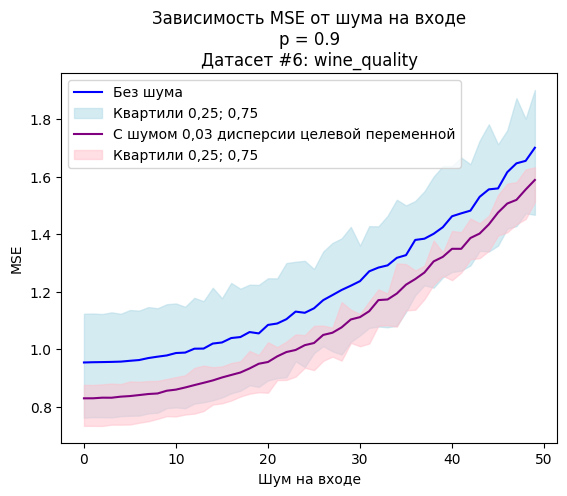

In [5]:
## Regular

import json

import pandas as pd

import matplotlib.pyplot as plt

from cgtnnlib.analyze import plot_deviant_curves_on_ax_or_plt



def read_json(path: str) -> dict:
    with open(path) as file:
        return json.load(file)

def summarize_series_list(series_list: list[pd.Series]):
    df = pd.DataFrame(series_list).T

    summary_df = pd.DataFrame({
        0.25: df.quantile(0.25, axis=1),
        0.75: df.quantile(0.75, axis=1),
        'mean': df.mean(axis=1),
    })

    return summary_df

for dataset in datasets:
    for p in pp:
        prefixes = [
            f'cgtnn-{dataset.number}Y-AugmentedReLUNetwork-g{ng_maker(dataset).name}-P{p}_'
            for ng_maker in ng_makers
        ]
        
        files = [
            [
                pd.DataFrame(
                    read_json(
                        'pth/' + prefix + 'N' + str(n) + '.json'
                    )['eval']
                )
                for n in range(iterations)
            ]
            for prefix in prefixes
        ]

        no_noise = summarize_series_list([file['mse'] for file in files[0]])
        some_noise = summarize_series_list([file['mse'] for file in files[1]])

        print(no_noise)
        
        plot_deviant_curves_on_ax_or_plt(
            ax_or_plt=plt,
            models=[{
                'curve': no_noise,
                'color': 'blue',
                'label': 'Без шума',
                'quantiles_color': 'lightblue',
                'quantiles_label': 'Квартили 0,25; 0,75',
            }, {
                'curve': some_noise,
                'color': 'purple',
                'label': 'С шумом 0,03 дисперсии целевой переменной',
                'quantiles_color': 'pink',
                'quantiles_label': 'Квартили 0,25; 0,75', 
            }],
            title='\n'.join([
                # 'Кривая потерь, обучение с +0.03 шумом на входе',
                'Зависимость MSE от шума на входе',
                f'p = {p}',
                f'Датасет #{dataset.number}: {dataset.name}'
            ]),
            xlabel='Шум на входе',
            ylabel='MSE',
            quantiles_alpha=0.5,
        )
        plt.show()

pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N0.json


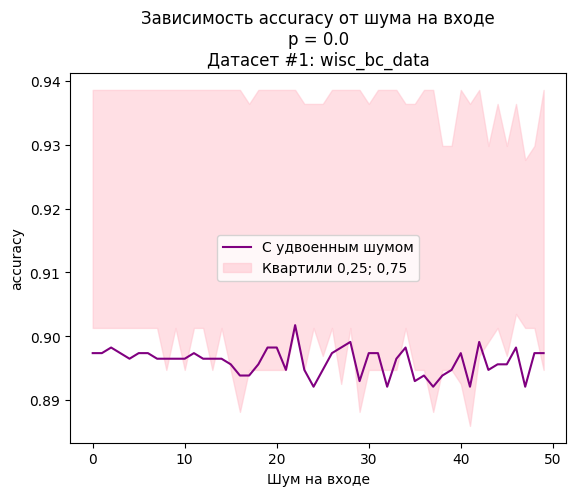

pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.5_N0.json


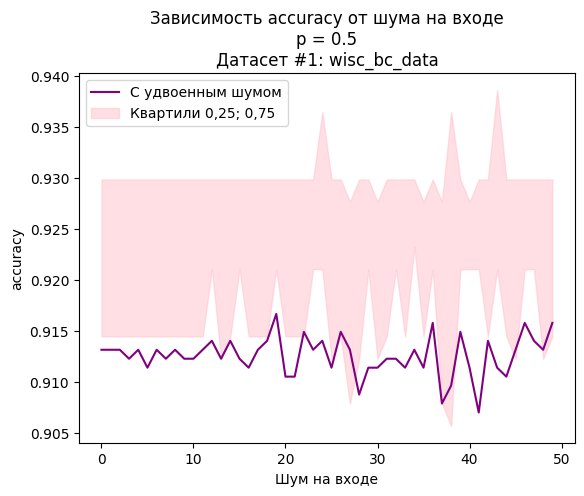

pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.9_N0.json


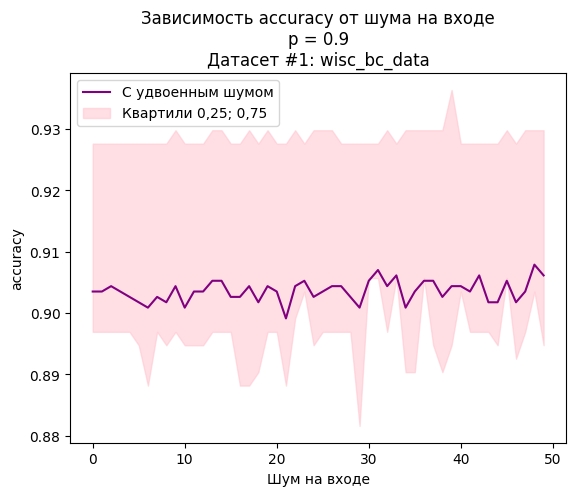

pth/cgtnn-2Y-AugmentedReLUNetwork-gNoNoise-P0.0_N0.json


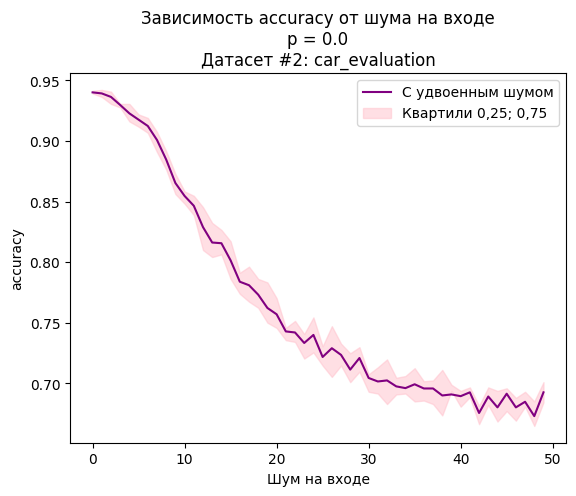

pth/cgtnn-2Y-AugmentedReLUNetwork-gNoNoise-P0.5_N0.json


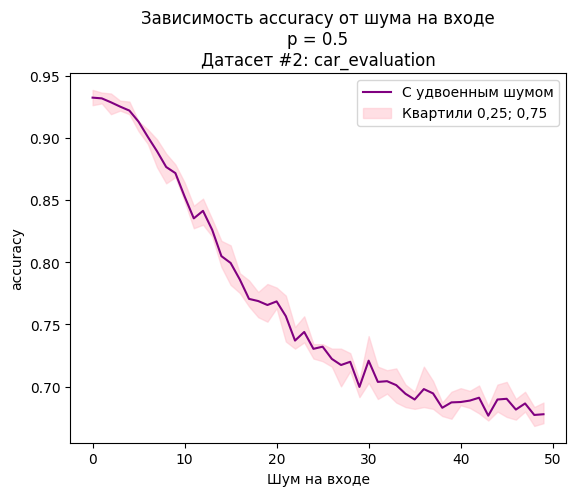

pth/cgtnn-2Y-AugmentedReLUNetwork-gNoNoise-P0.9_N0.json


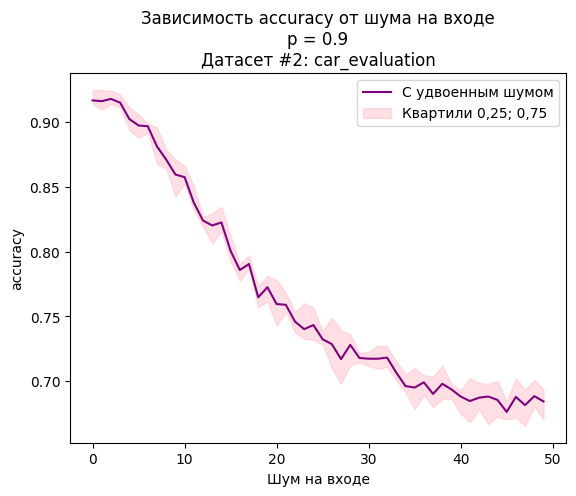

pth/cgtnn-5Y-AugmentedReLUNetwork-gNoNoise-P0.0_N0.json


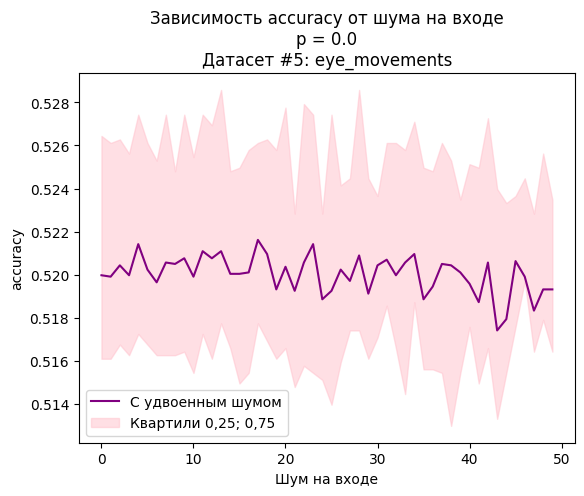

pth/cgtnn-5Y-AugmentedReLUNetwork-gNoNoise-P0.5_N0.json


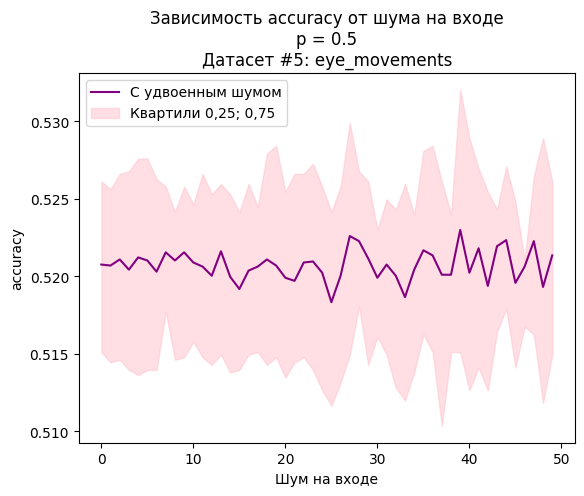

pth/cgtnn-5Y-AugmentedReLUNetwork-gNoNoise-P0.9_N0.json


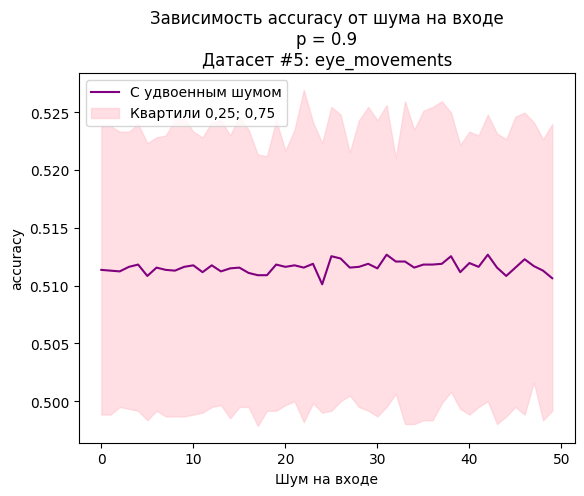

pth/cgtnn-7Y-AugmentedReLUNetwork-gNoNoise-P0.0_N0.json


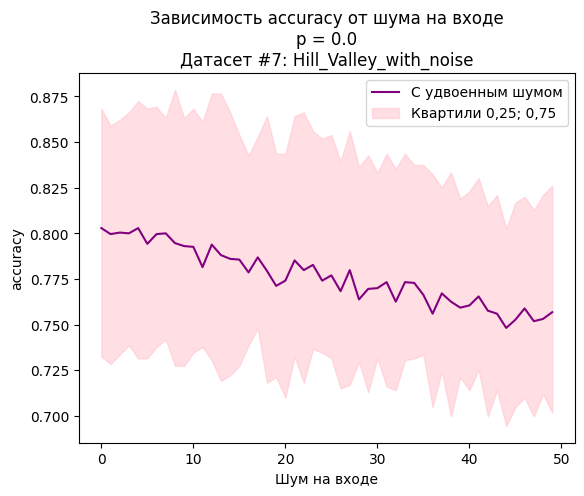

pth/cgtnn-7Y-AugmentedReLUNetwork-gNoNoise-P0.5_N0.json


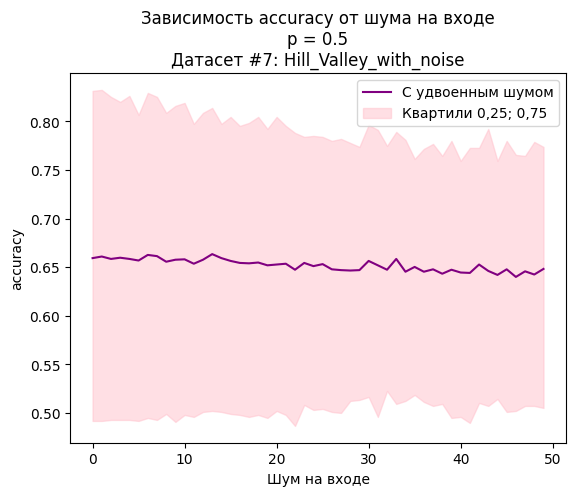

pth/cgtnn-7Y-AugmentedReLUNetwork-gNoNoise-P0.9_N0.json


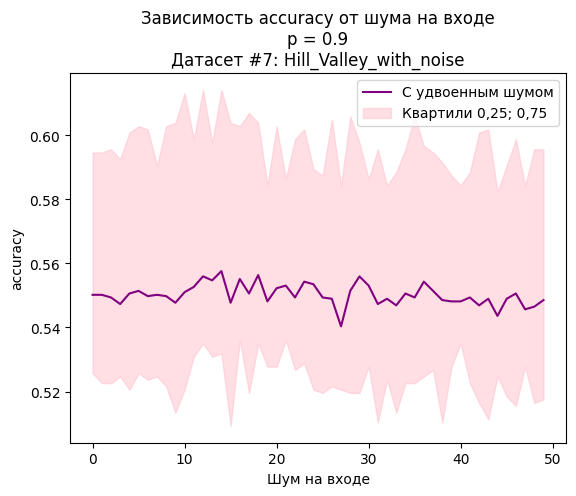

pth/cgtnn-8Y-AugmentedReLUNetwork-gNoNoise-P0.0_N0.json


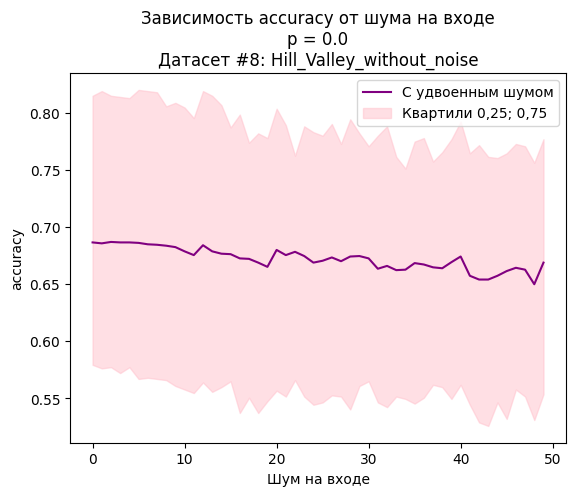

pth/cgtnn-8Y-AugmentedReLUNetwork-gNoNoise-P0.5_N0.json


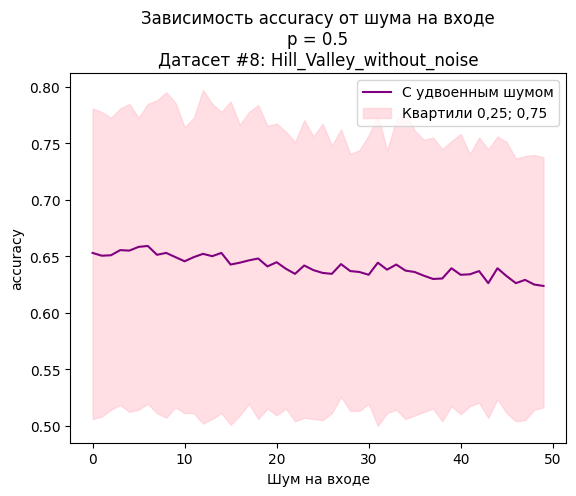

pth/cgtnn-8Y-AugmentedReLUNetwork-gNoNoise-P0.9_N0.json


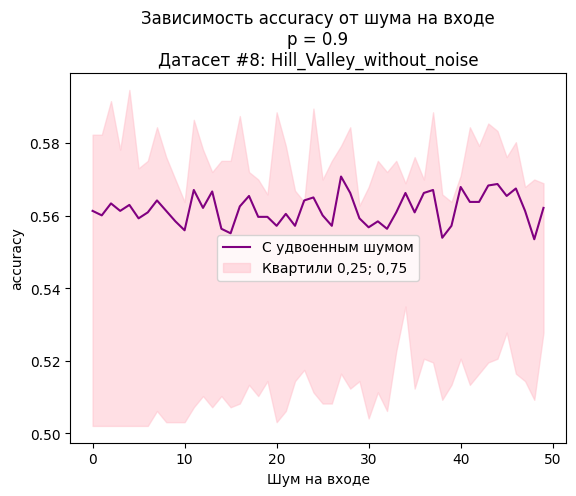

In [17]:
## 2x epochs

import json

import pandas as pd

import matplotlib.pyplot as plt

from cgtnnlib.analyze import plot_deviant_curves_on_ax_or_plt



def read_json(path: str) -> dict:
    with open(path) as file:
        return json.load(file)

def summarize_series_list(series_list: list[pd.Series]):
    df = pd.DataFrame(series_list).T

    summary_df = pd.DataFrame({
        0.25: df.quantile(0.25, axis=1),
        0.75: df.quantile(0.75, axis=1),
        'mean': df.mean(axis=1),
    })

    return summary_df

for i, dataset in enumerate(double_epochs_datasets):
    for p in pp:
        prefix = (
            f'cgtnn-{dataset.number}Y-AugmentedReLUNetwork'
            +f'-g{no_noise_generator.name}-P{p}_'
        )

        metric = 'accuracy'

        def filename(n):
            return f'pth/{prefix}N{n}.json'

        files = [
            pd.DataFrame(
                read_json(filename(n))['eval']
            )
            for n in range(iterations)
        ]
        
        print(filename(0))

        double_epochs = summarize_series_list([file[metric] for file in files])

        plot_deviant_curves_on_ax_or_plt(
            ax_or_plt=plt,
            models=[{
                'curve': double_epochs,
                'color': 'purple',
                'label': 'С удвоенным шумом',
                'quantiles_color': 'pink',
                'quantiles_label': 'Квартили 0,25; 0,75', 
            }],
            title='\n'.join([
                # 'Кривая потерь, обучение с +0.03 шумом на входе',
                f'Зависимость {metric} от шума на входе',
                f'p = {p}',
                f'Датасет #{dataset.number}: {dataset.name}'
            ]),
            xlabel='Шум на входе',
            ylabel=metric,
            quantiles_alpha=0.5,
        )
        plt.show()

## References

1. Chambers, J. M., Mallows, C. L., & Stuck, B. W. (1976). A method for simulating stable random variables. *Journal of the American Statistical Association*, *71*(354), 340-344.
2. M. Firouzi, A. Mohammadpour. A Survey on Simulating Stable Random Variables. URL: https://www.semanticscholar.org/reader/11a1e93642dc0a5c94e6906bcca5e4d25d4e9d46